In [34]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import random
import model
import multi_modal_model
from VAAL_solver import VAAL_Solver
from utils import *
from unet import UNet
import wandb
import warnings
warnings.filterwarnings("ignore")

# fix some of the parameters
scale = 0
resize = 256
#num_classes = 4
num_classes = 5
#checkpoint = 'checkpoints/Expt_random_sampling_full_dataset_no_less_than_3_classes_random_sample_0/checkpoint0.35.pth'
checkpoint = 'checkpoints/Expt_random_sampling_full_dataset_2_classes_random_sample_10/checkpoint0.35.pth'
net =  UNet(n_channels=3, n_classes=num_classes)
net.load_state_dict(torch.load(checkpoint))


def load_images(img_dir, mask_dir):

    image = Image.open(img_dir).convert('RGB')
    mask = Image.open(mask_dir).convert('RGB')

    # some image transformations 
    transform_x = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5],
                std=[0.5,0.5,0.5])
            ])
    transform_y = transforms.Compose([
        transforms.ToTensor()
    ])

    image, mask = preprocess(image, mask, depth= None, transform= transform_x, target_transform= transform_y, scale = 0, flip= False, resize= resize)
    mask = encode_target(mask)
    return image, mask
        


    
def encode_target(target):

    # Based on https://github.com/mcordts/cityscapesScripts
    Seg_classes = namedtuple('Class', ['name', 'train_id','color', 'color_name'])
    classes = [
    Seg_classes('liver', 0, (0, 0, 255), 'blue'),
    Seg_classes('stomach', 1, (255, 0, 0), 'red'),
    Seg_classes('abdominal wall', 2, (0, 255, 0), 'green'),
    Seg_classes('gallbladder', 3, (0, 255, 255), 'cyan'),
    Seg_classes('ligament', 4, (255, 0, 255), 'magenta')]

    colors = [c.color for c in classes ]
    train_ids = [c.train_id for c in classes]
    color_to_train_ids = dict(zip(colors,train_ids))
    train_ids_to_color = dict(zip(train_ids,colors))

    c,h,w = target.shape
    new_mask = torch.empty(h, w, dtype=torch.long)
    for k in color_to_train_ids:
        # Get all indices for current class
        idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
        validx = (idx.sum(0) == 3)  # Check that all channels match
        new_mask[validx] = torch.tensor(color_to_train_ids[k], dtype=torch.long)
    
    return new_mask

def decode_target(target):


    # Based on https://github.com/mcordts/cityscapesScripts
    Seg_classes = namedtuple('Class', ['name', 'train_id','color', 'color_name'])
    classes = [
    Seg_classes('liver', 0, (0, 0, 255), 'blue'),
    Seg_classes('stomach', 1, (255, 0, 0), 'red'),
    Seg_classes('abdominal wall', 2, (0, 255, 0), 'green'),
    Seg_classes('gallbladder', 3, (0, 255, 255), 'cyan'),
    Seg_classes('ligament', 4, (255, 0, 255), 'magenta')]

    colors = [c.color for c in classes ]
    train_ids = [c.train_id for c in classes]
    color_to_train_ids = dict(zip(colors,train_ids))
    train_ids_to_color = dict(zip(train_ids,colors))

    h,w = target.shape
    new_mask = torch.zeros(h, w, 3, dtype=torch.uint8)
    for k in train_ids_to_color:
        # Get all indices for current class
        idx = (target==torch.tensor(k, dtype=torch.long))
        new_mask[idx] = torch.tensor(train_ids_to_color[k], dtype=torch.uint8)
    return new_mask

def preprocess(image, mask, depth= None, transform = None, target_transform = None, depth_transform = None, flip=False, resize = None, scale=None, crop=None):
    if flip:
        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            if depth is not None:
                depth = depth.transpose(Image.FLIP_LEFT_RIGHT)

    
    if scale :
        w, h = image.size
        rand_log_scale = math.log(scale[0], 2) + random.random() * (math.log(scale[1], 2) - math.log(scale[0], 2))
        random_scale = math.pow(2, rand_log_scale)
        new_size = (int(round(w * random_scale)), int(round(h * random_scale)))
        image = image.resize(new_size, Image.ANTIALIAS)
        mask = mask.resize(new_size, Image.NEAREST)
        if depth is not None:
            depth = depth.resize(new_size, Image.NEAREST)

    if resize:
        image = image.resize((resize,resize), Image.ANTIALIAS)
        mask = mask.resize((resize,resize), Image.NEAREST)
        
        if depth is not None:
            depth = depth.resize((resize,resize), Image.NEAREST)


    if transform:
        image = transform(image)
    if target_transform:
        mask = 255 * target_transform(mask)

    if depth is not None:
        if depth_transform:
            depth = target_transform(depth)

    mask = mask.long()
    if depth is not None:
        return image, mask, depth
    else:
        return image, mask



def test_task(img):
    with torch.no_grad():
        mask_pred = net(img)
    return mask_pred

# npy containing list of paths of images that you want to test
test_files = (numpy.load('test_files_filtered_gallbladder_less_than_3_classes.npy', allow_pickle='TRUE')).item()
image_files = test_files['images'].tolist()
mask_files = test_files['masks'].tolist()
depth_files = test_files['depths'].tolist()


images= []
masks = []
preds = []
for i, (img, mask) in enumerate(zip(image_files,mask_files)):

    im, m  = load_images(img, mask)
   

    # add the batch channel
    im_batched = torch.unsqueeze(im, 0)
    m_batched = torch.unsqueeze(m, 0)
    
    # make the prediciton
    pred = test_task(im_batched)
    images.append(im)
    masks.append(decode_target(m))

    # highest probability class
    pred = pred.argmax(dim=1)[0]
    preds.append(decode_target(pred))
    if i > 5:
        break

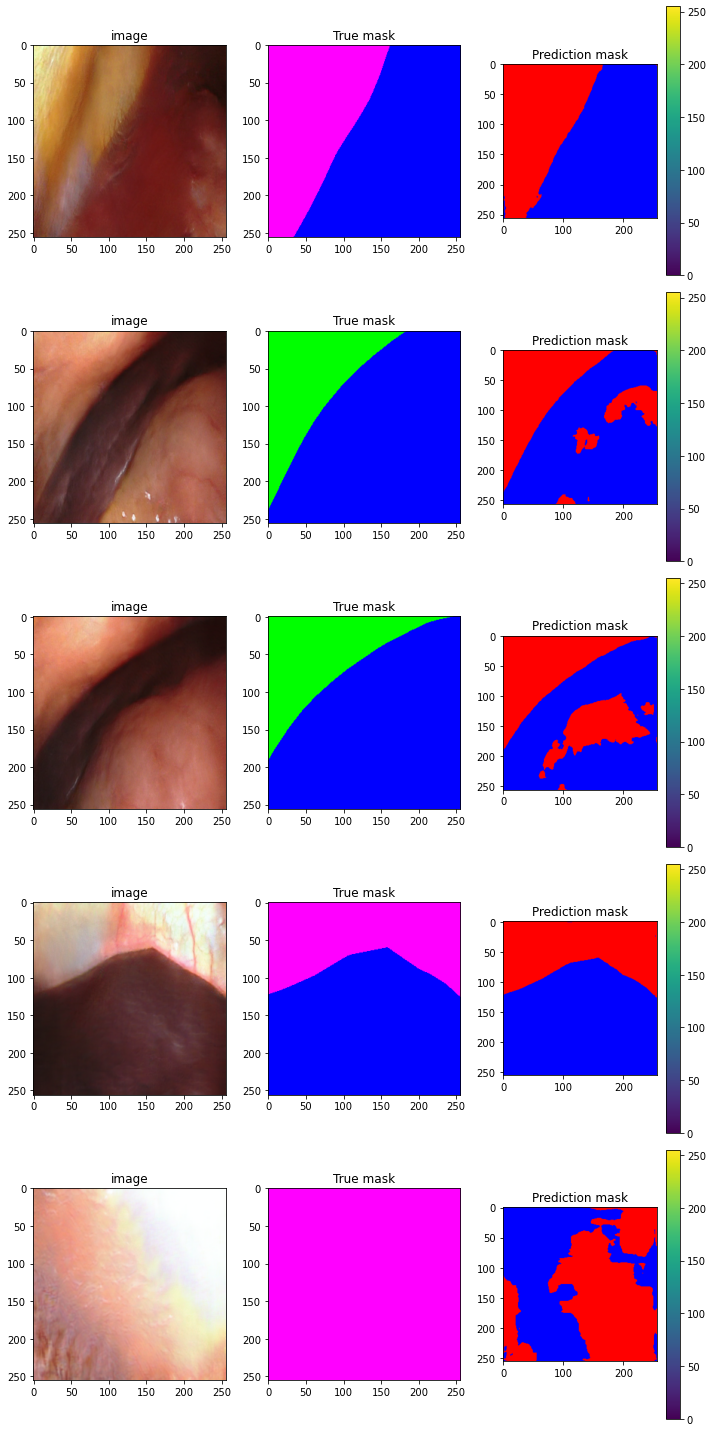

In [35]:
import matplotlib.pyplot as plt
# visualize the images 
f, axarr = plt.subplots(5,3, figsize = (10,20))
cnt = 0
for i in range(5):
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    axarr[i,0].imshow(invTrans(images[i]).permute(1,2,0))
    axarr[i,0].set_title("image")

    axarr[i,1].imshow(masks[i])
    axarr[i,1].set_title("True mask")
    
    
    d = axarr[i,2].imshow(preds[i].squeeze(0))
    axarr[i,2].set_title("Prediction mask")
    plt.colorbar(d, ax=axarr[i, 2])

    plt.tight_layout()

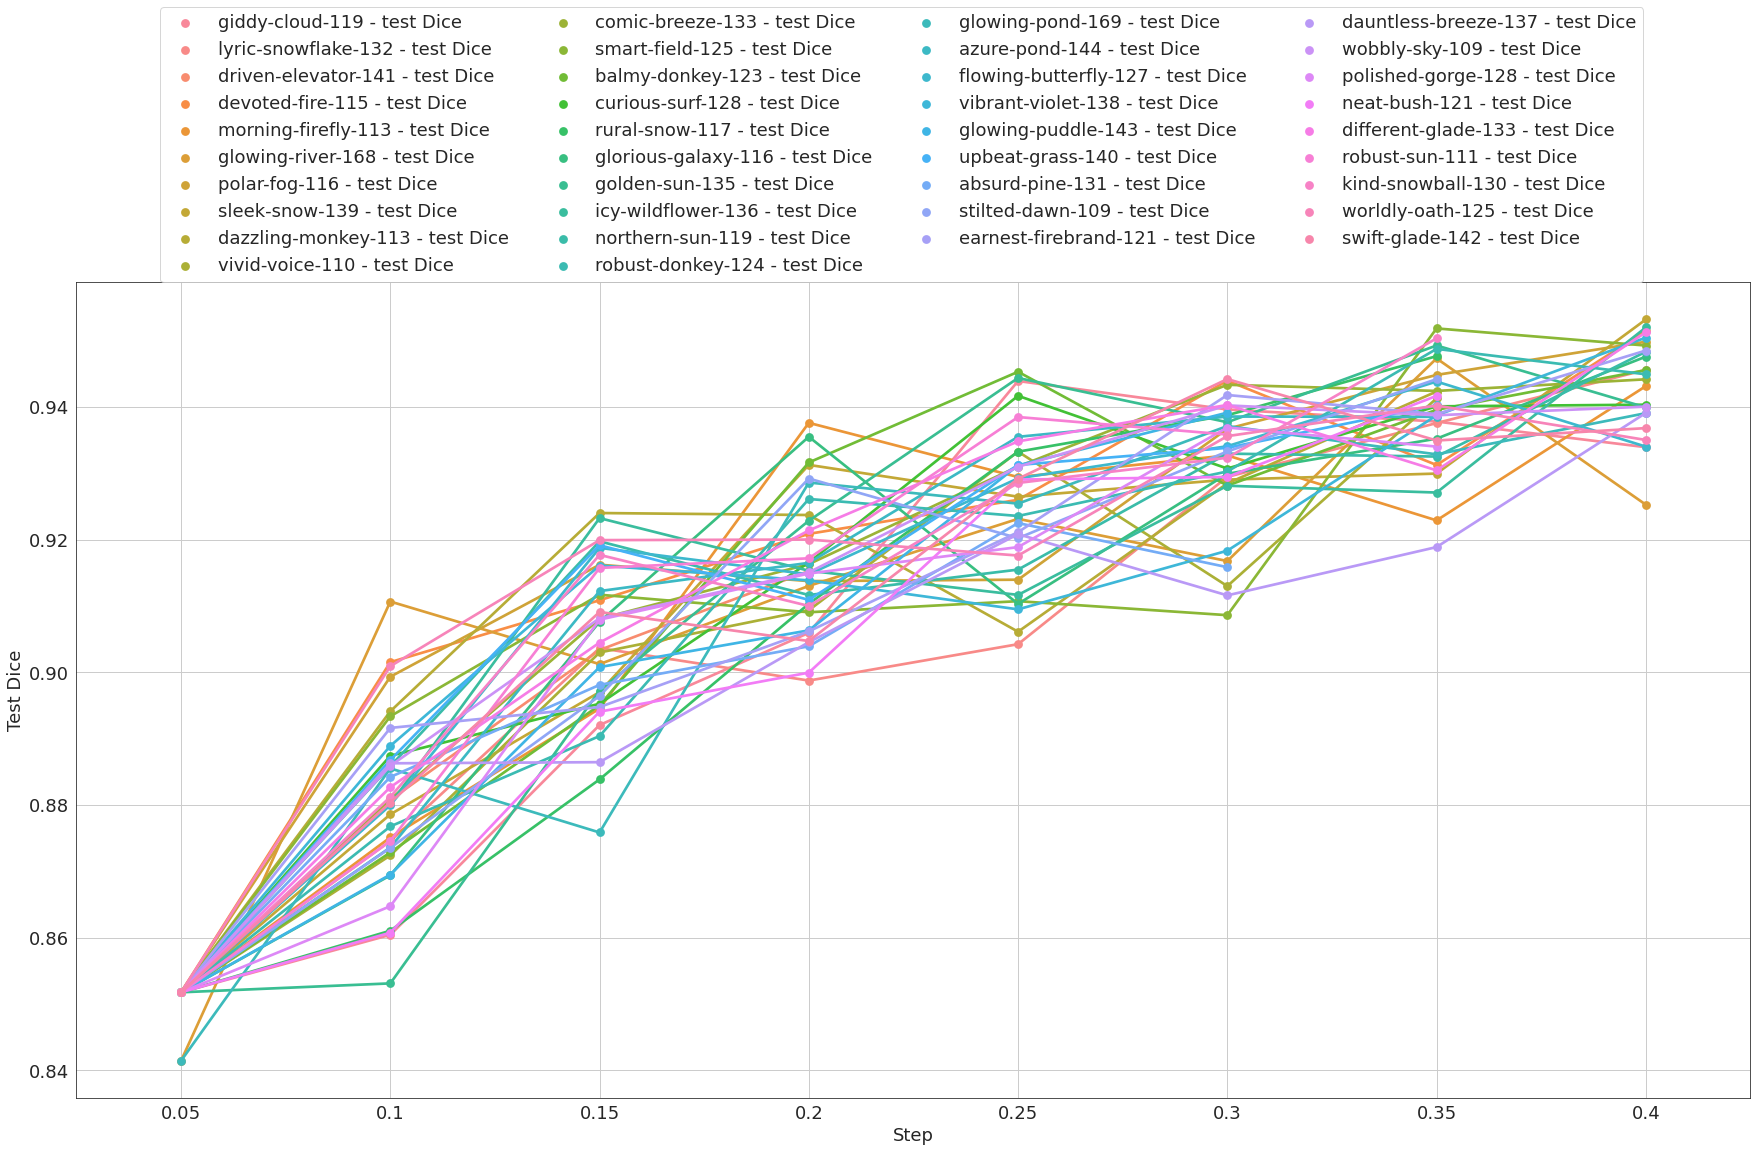

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import *
import re
sns.set_style("white")
matplotlib.rcParams.update({'font.size': 18})

data = pd.read_csv("RC_final_1.csv")
data = data[data.columns.drop(list(data.filter(regex='.*(?<!test Dice)$')))]
samples = [850*i for i in range(1,9,1)]
splits = [0.05, 0.1,0.15,0.2,0.25,0.3,0.35,0.4]
data['Step'] = splits

dfm = data.melt('Step', var_name='cols', value_name='Test Dice')

fig = plt.figure(figsize=(30,15))
sns.pointplot(x="Step", y ="Test Dice", hue='cols', data=dfm)
plt.legend(loc=(0.05,1), ncol=4)
plt.grid(linestyle='-', linewidth=1)


## Visualize the Outputs of the Decoder of VAE

In [90]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import random
import model
import multi_modal_model
from VAAL_solver import VAAL_Solver
from utils import *
from unet import UNet
import wandb
import warnings
from exr_data import readEXR
warnings.filterwarnings("ignore")

# fix some of the parameters
scale = 0
resize = 256
checkpoint = 'checkpoints/Expt_multimodal_VAAL_adversery_25/vae_checkpoint0.35.pth'
vae = multi_modal_model.VAE(64)
vae.load_state_dict(torch.load(checkpoint))


def load_images(img_dir, mask_dir, depth_dir):

    image = Image.open(img_dir).convert('RGB')
    mask = Image.open(mask_dir).convert('RGB')
    depth = readEXR(depth_dir)

    # some image transformations 
    transform_x = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5],
                std=[0.5,0.5,0.5])
            ])
    transform_y = transforms.Compose([
        transforms.ToTensor()
    ])

    transform_z = transforms.Compose([          
            transforms.ToTensor()
    ])

    image, mask, depth = preprocess(image, mask, depth= depth, transform= transform_x, target_transform= transform_y, depth_transform = transform_z, scale = 0, flip= False, resize= resize)
    return image, depth
        

def preprocess(image, mask, depth= None, transform = None, target_transform = None, depth_transform = None, flip=False, resize = None, scale=None, crop=None):
    if flip:
        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            if depth is not None:
                depth = depth.transpose(Image.FLIP_LEFT_RIGHT)
    
    if scale :
        w, h = image.size
        rand_log_scale = math.log(scale[0], 2) + random.random() * (math.log(scale[1], 2) - math.log(scale[0], 2))
        random_scale = math.pow(2, rand_log_scale)
        new_size = (int(round(w * random_scale)), int(round(h * random_scale)))
        image = image.resize(new_size, Image.ANTIALIAS)
        mask = mask.resize(new_size, Image.NEAREST)
        if depth is not None:
            depth = depth.resize(new_size, Image.NEAREST)

    if resize:
        image = image.resize((resize,resize), Image.ANTIALIAS)
        mask = mask.resize((resize,resize), Image.NEAREST)
        
        if depth is not None:
            depth = depth.resize((resize,resize), Image.NEAREST)


    if transform:
        image = transform(image)
    if target_transform:
        mask = 255 * target_transform(mask)

    if depth is not None:
        if depth_transform:
            depth = target_transform(depth)

    mask = mask.long()
    if depth is not None:
        return image, mask, depth
    else:
        return image, mask



def vae(img):
    with torch.no_grad():
        img = img.to(device=torch.device('cuda'), dtype=torch.float32)
        vae = vae.to(torch.device('cuda'))
        reconstructed_img, depth, z, _, _= vae(img)
    return recontructed_img, depth

# npy containing list of paths of images that you want to test
test_files = (numpy.load('test_files_filtered_gallbladder_less_than_3_classes.npy', allow_pickle='TRUE')).item()
image_files = test_files['images'].tolist()
mask_files = test_files['masks'].tolist()
depth_files = test_files['depths'].tolist()


images= []
depths = []
recons_imgs = []
pred_depths = []
for i, (img, mask, depth) in enumerate(zip(image_files,mask_files,depth_files)):


    

    im, d  = load_images(img, mask, depth)
   

    # add the batch channel
    im_batched = torch.unsqueeze(im, 0)

    # make the prediciton
    recons_img, pred_depth = vae(im_batched)
    images.append(im)
    depths.append(d)
    recons_imgs.append(recons_img[0].cpu().numpy())
    pred_depths.append(pred_depth[0].cpu().numpy())

    if i > 5:
        break

AttributeError: 'function' object has no attribute 'to'

In [ ]:
import matplotlib.pyplot as plt
# visualize the images 
f, axarr = plt.subplots(5,4, figsize = (10,20))
cnt = 0
for i in range(5):
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    axarr[i,0].imshow(invTrans(images[i]).permute(1,2,0))
    axarr[i,0].set_title("Image")

    axarr[i,1].imshow(recons_imgs[i])
    axarr[i,1].set_title("Reconstructed Image")
    
    
    d = axarr[i,2].imshow(depths[i])
    axarr[i,2].set_title("Depth")
    plt.colorbar(d, ax=axarr[i, 2])

    d = axarr[i,3].imshow(pred_depths[i])
    axarr[i,2].set_title("Predicted Depth")
    plt.colorbar(d, ax=axarr[i, 3])

    plt.tight_layout()